In [3]:
import pandas as pd
from prophet import Prophet
import yfinance as yf
import matplotlib.pyplot as plt

# 抓一檔股票的歷史資料 (台達電)

In [ ]:
# 台積電股票
yahoo = yf.Ticker("2308.TW").history(period="max") #max能抓到的全部歷史資料
yahoo.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2000-01-04 00:00:00+08:00,24.389181,25.448042,24.389181,24.831110,51510536,0.0,0.0
2000-01-05 00:00:00+08:00,24.389180,24.917727,24.124023,24.300795,34281452,0.0,0.0
2000-01-06 00:00:00+08:00,24.565953,25.803354,24.565953,25.803354,86427970,0.0,0.0
2000-01-07 00:00:00+08:00,25.626584,25.626584,24.744493,25.096270,43741129,0.0,0.0
2000-01-10 00:00:00+08:00,25.361429,26.685450,25.182889,26.685450,69470477,0.0,0.0


<Axes: xlabel='Date'>

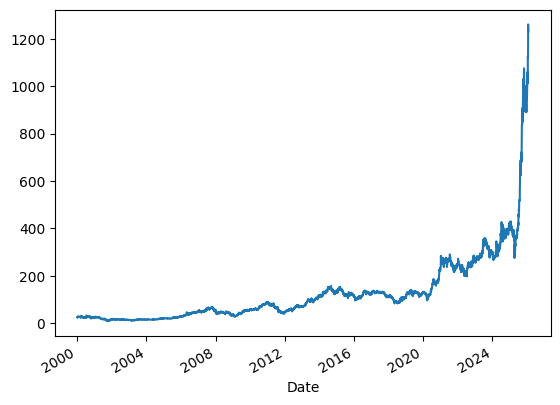

In [28]:
yahoo['Close'].plot() #畫走勢圖

# 把日期從 index 變成欄位（Prophet 需要欄位，不吃 index）

In [29]:
yahoo.reset_index(inplace=True, drop=False)

In [ ]:
yahoo.tail() #會出現 Date

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
6481,2026-01-20 00:00:00+08:00,1105.0,1140.0,1100.0,1130.0,7198430,0.0,0.0
6482,2026-01-21 00:00:00+08:00,1130.0,1185.0,1115.0,1135.0,18083264,0.0,0.0
6483,2026-01-22 00:00:00+08:00,1200.0,1245.0,1195.0,1245.0,19318986,0.0,0.0
6484,2026-01-23 00:00:00+08:00,1280.0,1285.0,1245.0,1260.0,17512693,0.0,0.0
6485,2026-01-26 00:00:00+08:00,1220.0,1240.0,1205.0,1230.0,12674207,0.0,0.0


## 整理成 Prophet 固定格式：ds / y

In [32]:
df = yahoo[['Date', 'Close']].set_axis(['ds', 'y'], axis='columns')

In [9]:
df.head()

,ds,y
0,2000-01-04 00:00:00+08:00,33.538113
1,2000-01-05 00:00:00+08:00,34.291714
2,2000-01-06 00:00:00+08:00,33.538113
3,2000-01-07 00:00:00+08:00,32.595974
4,2000-01-10 00:00:00+08:00,33.726463


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6486 entries, 0 to 6485
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype                      
---  ------  --------------  -----                      
 0   ds      6486 non-null   datetime64[ns, Asia/Taipei]
 1   y       6486 non-null   float64                    
dtypes: datetime64[ns, Asia/Taipei](1), float64(1)
memory usage: 101.5 KB


In [34]:
df['ds'] = df['ds'].dt.tz_localize(None) #移除時區資訊（Prophet 常見地雷）

# 1. Basic 建立模型

In [ ]:
m = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    
) #y(t) = 趨勢 + 季節性 + 假日/事件 + 誤差
m.fit(df)

19:48:09 - cmdstanpy - INFO - Chain [1] start processing
19:48:09 - cmdstanpy - INFO - Chain [1] done processing


In [36]:
future = m.make_future_dataframe(periods=30)
future.tail()

,ds
6511,2026-02-21
6512,2026-02-22
6513,2026-02-23
6514,2026-02-24
6515,2026-02-25


In [37]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
6511,2026-02-21,574.095860,498.278267,654.936343
6512,2026-02-22,574.483396,498.037014,653.883649
6513,2026-02-23,574.879532,503.531190,651.216126
6514,2026-02-24,575.276334,504.477708,653.893805
6515,2026-02-25,575.666936,497.430003,662.965248


In [38]:
import sys

In [39]:
from prophet.plot import plot_plotly, plot_components_plotly
plot_plotly(m, forecast)
plot_components_plotly(m, forecast)

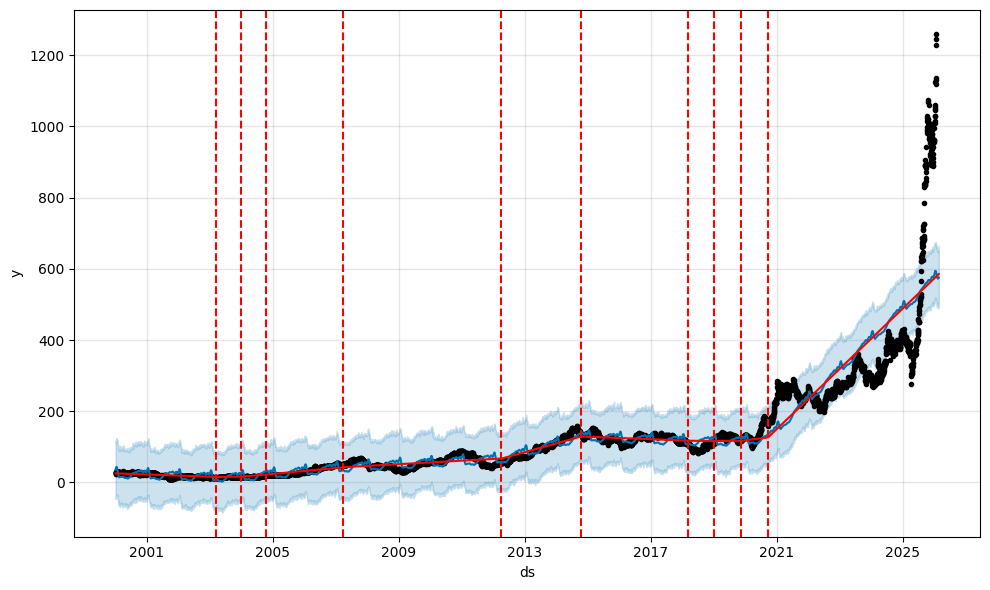

In [40]:
from prophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

In [41]:
m = Prophet()
m.add_country_holidays(country_name='CN')
m.fit(df)

19:49:18 - cmdstanpy - INFO - Chain [1] start processing
19:49:25 - cmdstanpy - INFO - Chain [1] done processing


In [42]:
m.train_holiday_names

0                             New Year's Day
1         Chinese New Year (Spring Festival)
2                                  Labor Day
3                               National Day
4                  New Year's Day (observed)
                       ...                  
182    Day off (substituted from 02/14/2026)
183    Day off (substituted from 02/28/2026)
184    Day off (substituted from 05/09/2026)
185    Day off (substituted from 09/20/2026)
186    Day off (substituted from 10/10/2026)
Length: 187, dtype: object

In [43]:
forecast = m.predict(future)
plot_components_plotly(m, forecast)

In [44]:
election = pd.DataFrame({
  'holiday': 'playoff',
  'ds': pd.to_datetime(['2000-03-18', '2004-03-20', '2008-03-22',
                        '2012-01-14', '2016-01-16', '2020-01-11']),
  'lower_window': 0,
  'upper_window': 1,
})
m = Prophet(holidays=election)
m.fit(df)

19:50:16 - cmdstanpy - INFO - Chain [1] start processing
19:50:17 - cmdstanpy - INFO - Chain [1] done processing


In [45]:
m = Prophet(
    holidays=election)
m.fit(df)

19:50:22 - cmdstanpy - INFO - Chain [1] start processing
19:50:23 - cmdstanpy - INFO - Chain [1] done processing


In [46]:
forecast = m.predict(future)
plot_components_plotly(m, forecast)

In [47]:
lockdowns = pd.DataFrame([
    {'holiday': 'lockdown_1', 'ds': '2020-03-21', 'lower_window': 0, 'ds_upper': '2020-06-06'},
    {'holiday': 'lockdown_2', 'ds': '2020-07-09', 'lower_window': 0, 'ds_upper': '2020-10-27'},
    {'holiday': 'lockdown_3', 'ds': '2021-02-13', 'lower_window': 0, 'ds_upper': '2021-02-17'},
    {'holiday': 'lockdown_4', 'ds': '2021-05-28', 'lower_window': 0, 'ds_upper': '2021-06-10'},
])
for t_col in ['ds', 'ds_upper']:
    lockdowns[t_col] = pd.to_datetime(lockdowns[t_col])
lockdowns['upper_window'] = (lockdowns['ds_upper'] - lockdowns['ds']).dt.days
lockdowns

,holiday,ds,lower_window,ds_upper,upper_window
0,lockdown_1,2020-03-21,0,2020-06-06,77
1,lockdown_2,2020-07-09,0,2020-10-27,110
2,lockdown_3,2021-02-13,0,2021-02-17,4
3,lockdown_4,2021-05-28,0,2021-06-10,13


In [48]:
m2 = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    holidays=lockdowns)
m2 = m2.fit(df)
future2 = m2.make_future_dataframe(periods=366)
forecast2 = m2.predict(future2)

19:50:47 - cmdstanpy - INFO - Chain [1] start processing
19:50:51 - cmdstanpy - INFO - Chain [1] done processing


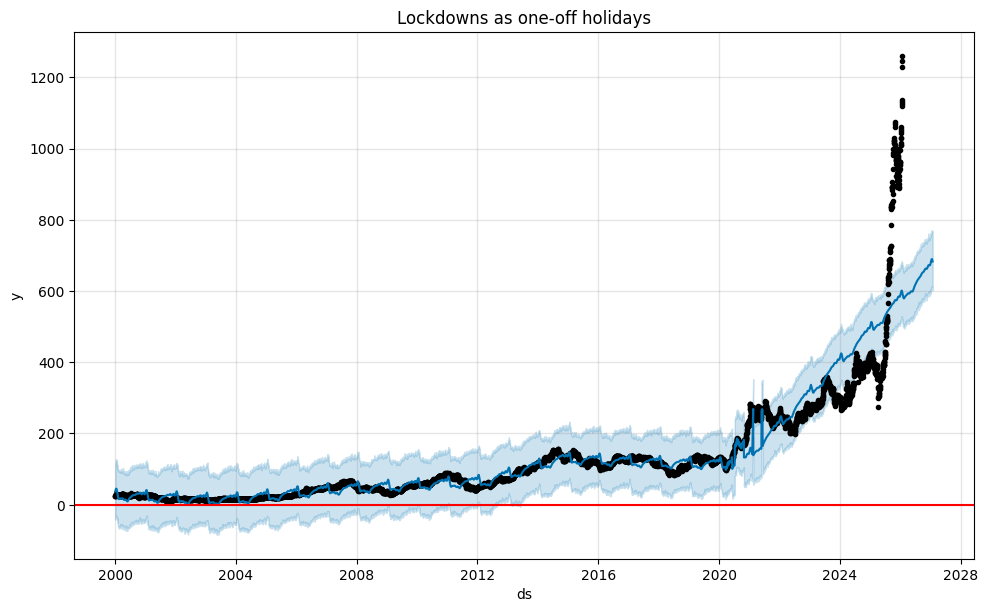

In [49]:
m2.plot(forecast2)
plt.axhline(y=0, color='red')
plt.title('Lockdowns as one-off holidays');

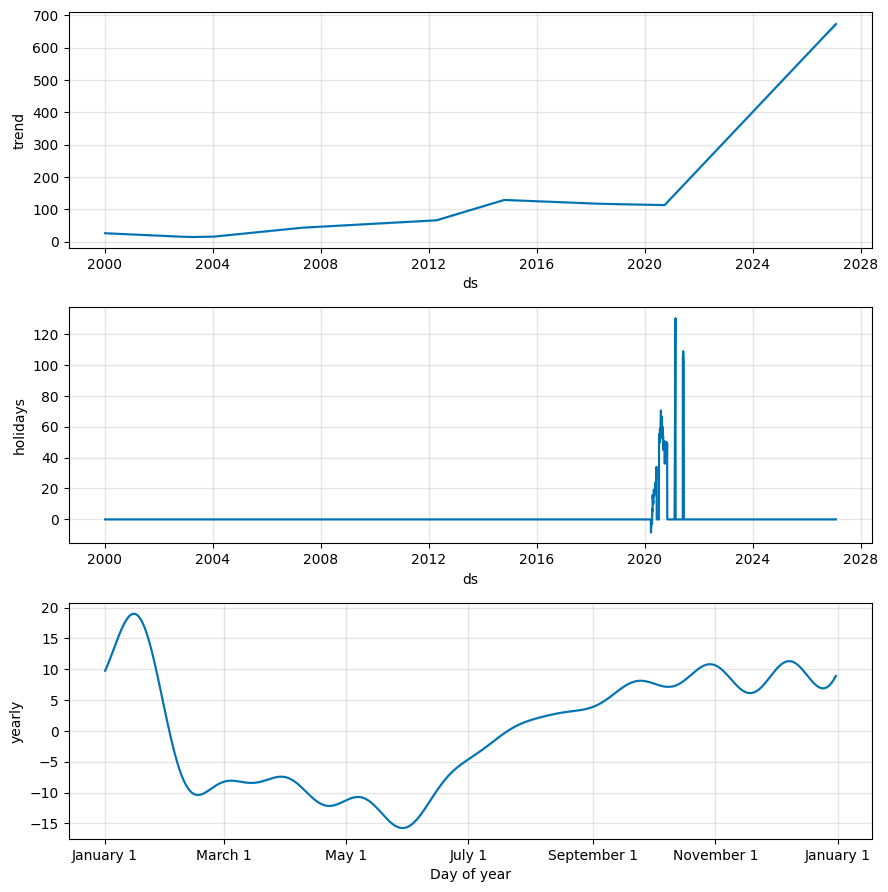

In [50]:
m2.plot_components(forecast2);

In [51]:
forecast = m2.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
6511,2026-02-21,581.179091,499.478110,662.324911
6512,2026-02-22,581.636085,504.059384,658.931842
6513,2026-02-23,582.102511,505.527585,664.620477
6514,2026-02-24,582.568939,504.247702,658.753062
6515,2026-02-25,583.027063,499.605678,663.390925


In [52]:
print("df 最後一筆：", df.tail(1))
print("raw Close 最後一筆：", yahoo[['Date','Close']].tail(1))

df 最後一筆：              ds       y
6485 2026-01-26  1230.0
raw Close 最後一筆：                           Date   Close
6485 2026-01-26 00:00:00+08:00  1230.0


In [53]:
last_day = df['ds'].iloc[-1]
actual_last = df['y'].iloc[-1]
pred_last = forecast2.loc[forecast2['ds'] == last_day, 'yhat'].iloc[0]

print("最後一天實際 y =", actual_last)
print("最後一天模型 yhat =", pred_last)

最後一天實際 y = 1230.0
最後一天模型 yhat = 595.6323285227968


20:00:19 - cmdstanpy - INFO - Chain [1] start processing
20:00:21 - cmdstanpy - INFO - Chain [1] done processing


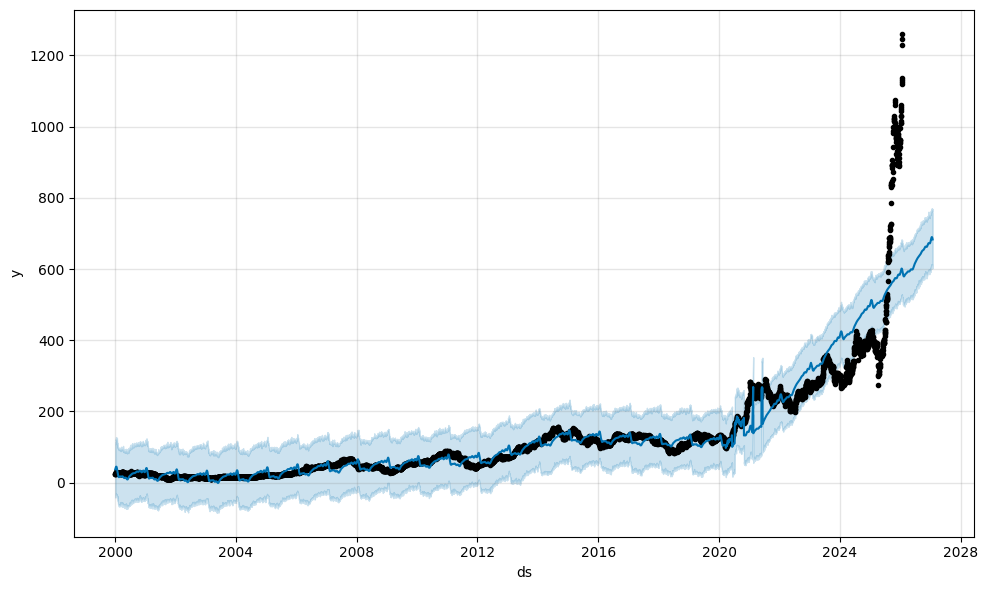

In [55]:
m3 = Prophet(
    yearly_seasonality=True,
    changepoint_prior_scale=0.5,  # 0.05 -> 0.5（更敢轉彎）
    changepoint_range=0.95        # 更關注最後一段
)
m3.fit(df)

future3 = m3.make_future_dataframe(periods=30)
forecast3 = m3.predict(future2)
m2.plot(forecast2);

In [56]:
forecast = m3.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
6511,2026-02-21,950.479356,905.053066,994.807961
6512,2026-02-22,951.748812,906.225928,997.277332
6513,2026-02-23,956.777467,912.863395,1004.331874
6514,2026-02-24,958.161042,914.967034,1003.689388
6515,2026-02-25,959.494462,910.543133,1006.300661


In [58]:
last_day = df['ds'].iloc[-1]
actual_last = df['y'].iloc[-1]
pred_last = forecast3.loc[forecast3['ds'] == last_day, 'yhat'].iloc[0]

print("最後一天實際 y =", actual_last)
print("最後一天模型 yhat =", pred_last)

最後一天實際 y = 1230.0
最後一天模型 yhat = 930.0924856539344


20:01:28 - cmdstanpy - INFO - Chain [1] start processing
20:01:28 - cmdstanpy - INFO - Chain [1] done processing


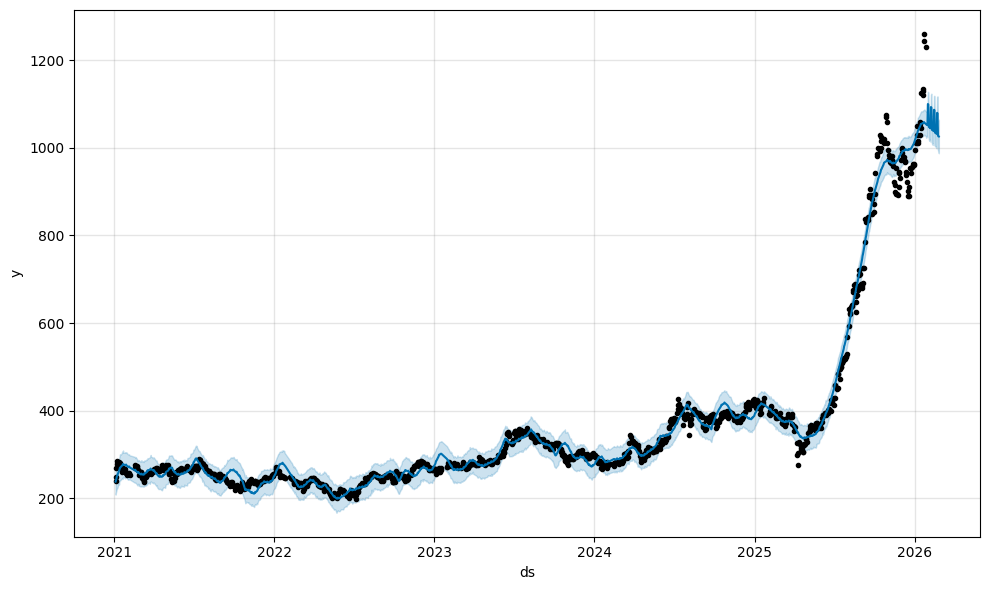

In [59]:
df_recent = df[df['ds'] >= "2021-01-01"].copy()

m_recent = Prophet(
    yearly_seasonality=True,
    changepoint_prior_scale=0.5
)
m_recent.fit(df_recent)

future_r = m_recent.make_future_dataframe(periods=30)
forecast_r = m_recent.predict(future_r)
m_recent.plot(forecast_r);

In [61]:
forecast = m_recent.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
6511,2026-02-21,1079.880619,1045.190038,1113.846469
6512,2026-02-22,1078.770979,1041.475650,1115.273412
6513,2026-02-23,1027.986347,991.051560,1066.065664
6514,2026-02-24,1026.406603,988.232148,1062.325761
6515,2026-02-25,1025.839672,989.929597,1063.687444


In [63]:
last_day = df['ds'].iloc[-1]
actual_last = df['y'].iloc[-1]
pred_last = forecast.loc[forecast['ds'] == last_day, 'yhat'].iloc[0]

print("最後一天實際 y =", actual_last)
print("最後一天模型 yhat =", pred_last)

最後一天實際 y = 1230.0
最後一天模型 yhat = 1054.9293430188875
